# 🔍 Error Analysis - Diabetes Risk Prediction Models

This notebook provides comprehensive error analysis for the baseline machine learning models developed in **Week 1-2** of the diabetes risk prediction project.

## 📋 **Error Analysis Pipeline:**
1. **📊 Load Model Results** - Import baseline model results and predictions
2. **🎯 Detailed Confusion Matrices** - In-depth confusion matrix analysis
3. **❌ Misclassification Patterns** - Analysis of prediction errors by model type
4. **📈 Feature Impact on Errors** - Understanding which features contribute to misclassifications
5. **🏥 Clinical Decision Analysis** - False positive vs false negative trade-offs
6. **📊 Model Reliability Assessment** - Prediction confidence and uncertainty analysis
7. **💡 Recommendations** - Actionable insights for model improvement

---
**Data Source:** Results from `03_modeling.ipynb` baseline training  
**Analysis Focus:** Understanding model weaknesses and improvement opportunities  
**Clinical Context:** Diabetes screening and early detection scenarios  
**Date:** December 19, 2025

## 🎯 **Week 1-2 Error Analysis Objectives:**

**Primary Goals:**
- Identify systematic prediction errors across all 5 baseline models
- Understand patient demographic and clinical patterns in misclassifications
- Assess clinical impact of false positives vs false negatives
- Provide data-driven recommendations for model improvement

**Models Under Analysis:**
1. **Logistic Regression** - Linear baseline interpretable model
2. **Random Forest** - Ensemble method with feature importance
3. **XGBoost** - Gradient boosting for high performance
4. **Support Vector Machine** - Non-linear classification
5. **PyTorch Neural Network** - Deep learning with Mac M1/M2 optimization

**Key Clinical Considerations:**
- **False Negatives:** Missed diabetes cases (higher clinical risk)
- **False Positives:** Unnecessary follow-up tests (resource impact)
- **Population Equity:** Performance across demographic groups
- **Intervention Thresholds:** Optimal decision boundaries for screening

**Expected Deliverables:**
- Comprehensive error pattern analysis
- Feature-based misclassification insights
- Clinical decision support recommendations
- Model improvement roadmap for Weeks 3-4

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import os
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Statistical Analysis
from scipy import stats
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score, brier_score_loss,
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, ConfusionMatrixDisplay
)

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seeds and style
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Error Analysis Libraries loaded successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📈 Matplotlib/Seaborn ready for visualizations")
print(f"🔍 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Random seed: {RANDOM_STATE}")

✅ Error Analysis Libraries loaded successfully!
📊 Pandas version: 2.3.3
📈 Matplotlib/Seaborn ready for visualizations
🔍 Analysis date: 2025-12-19 14:54:42
🎯 Random seed: 42


## 📊 1. Load Baseline Model Results
**Goal:** Import model results, predictions, and validation data from the baseline modeling phase.

In [3]:
# Load Baseline Model Results and Data
print("📊 LOADING BASELINE MODEL RESULTS:")
print("=" * 40)

# Load validation data first
data_paths = ['../data/processed', './data/processed', '../../data/processed']
data_loaded = False

for data_path in data_paths:
    if os.path.exists(data_path):
        try:
            X_val = pd.read_csv(os.path.join(data_path, 'X_val.csv'))
            y_val = pd.read_csv(os.path.join(data_path, 'y_val.csv'))
            
            if 'Unnamed: 0' in X_val.columns:
                X_val = X_val.drop('Unnamed: 0', axis=1)
            
            y_val = y_val.iloc[:, -1] if y_val.shape[1] > 1 else y_val.squeeze()
            
            print(f"✅ Validation data loaded from: {data_path}")
            print(f"📊 Validation set: {X_val.shape[0]:,} samples, {X_val.shape[1]} features")
            data_loaded = True
            break
        except Exception as e:
            continue

if not data_loaded:
    raise FileNotFoundError("❌ Could not load validation data")

# Load saved model results
results_dir = '../results'
model_results = {}

# Load performance comparison
perf_path = f'{results_dir}/models/baseline_performance_comparison.csv'
if os.path.exists(perf_path):
    performance_df = pd.read_csv(perf_path)
    print(f"✅ Performance data loaded: {len(performance_df)} models")
else:
    print("❌ Performance comparison file not found")

# Load individual model files
model_files = {
    'Logistic Regression': f'{results_dir}/models/baseline_logistic_regression.pkl',
    'Random Forest': f'{results_dir}/models/baseline_random_forest.pkl',
    'XGBoost': f'{results_dir}/models/baseline_xgboost.pkl',
    'SVM': f'{results_dir}/models/baseline_svm.pkl',
    'PyTorch Neural Network': f'{results_dir}/pytorch_neural_network_results.pkl'
}

# Load each model's results
for model_name, file_path in model_files.items():
    if os.path.exists(file_path):
        try:
            if model_name == 'PyTorch Neural Network':
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)
                model_results[model_name] = {
                    'predictions': np.array(data['predictions']),
                    'probabilities': np.array(data['probabilities']),
                    'metrics': {
                        'accuracy': data['accuracy'],
                        'precision': data['precision'], 
                        'recall': data['recall'],
                        'f1_score': data['f1_score'],
                        'roc_auc': data['roc_auc']
                    }
                }
            else:
                data = joblib.load(file_path)
                # We'll need to regenerate predictions since they weren't saved
                model = data['model']
                predictions = model.predict(X_val)
                probabilities = model.predict_proba(X_val)[:, 1]
                
                model_results[model_name] = {
                    'model': model,
                    'predictions': predictions,
                    'probabilities': probabilities,
                    'metrics': data['metrics']
                }
            print(f"✅ {model_name}: Loaded successfully")
        except Exception as e:
            print(f"❌ {model_name}: Error loading - {e}")

# Load misclassification analysis results
misclass_dir = f'{results_dir}/misclassification_analysis'
if os.path.exists(f'{misclass_dir}/misclassification_summary.csv'):
    misclass_summary = pd.read_csv(f'{misclass_dir}/misclassification_summary.csv')
    print(f"✅ Misclassification summary loaded: {len(misclass_summary)} models")

print(f"\n📋 LOADED RESULTS SUMMARY:")
print(f"   🎯 Models analyzed: {len(model_results)}")
print(f"   📊 Validation samples: {len(y_val):,}")
print(f"   📈 Feature count: {X_val.shape[1]}")
print(f"   ✅ Ready for comprehensive error analysis!")

📊 LOADING BASELINE MODEL RESULTS:
✅ Validation data loaded from: ../data/processed
📊 Validation set: 15,000 samples, 28 features
✅ Performance data loaded: 5 models
✅ Logistic Regression: Loaded successfully
✅ Random Forest: Loaded successfully
✅ XGBoost: Loaded successfully
✅ Random Forest: Loaded successfully
✅ XGBoost: Loaded successfully
✅ SVM: Loaded successfully
✅ PyTorch Neural Network: Loaded successfully
✅ Misclassification summary loaded: 5 models

📋 LOADED RESULTS SUMMARY:
   🎯 Models analyzed: 5
   📊 Validation samples: 15,000
   📈 Feature count: 28
   ✅ Ready for comprehensive error analysis!
✅ SVM: Loaded successfully
✅ PyTorch Neural Network: Loaded successfully
✅ Misclassification summary loaded: 5 models

📋 LOADED RESULTS SUMMARY:
   🎯 Models analyzed: 5
   📊 Validation samples: 15,000
   📈 Feature count: 28
   ✅ Ready for comprehensive error analysis!


## 🎯 2. Comprehensive Confusion Matrix Analysis
**Goal:** Deep-dive analysis of confusion matrices with clinical interpretation.

🎯 COMPREHENSIVE CONFUSION MATRIX ANALYSIS:


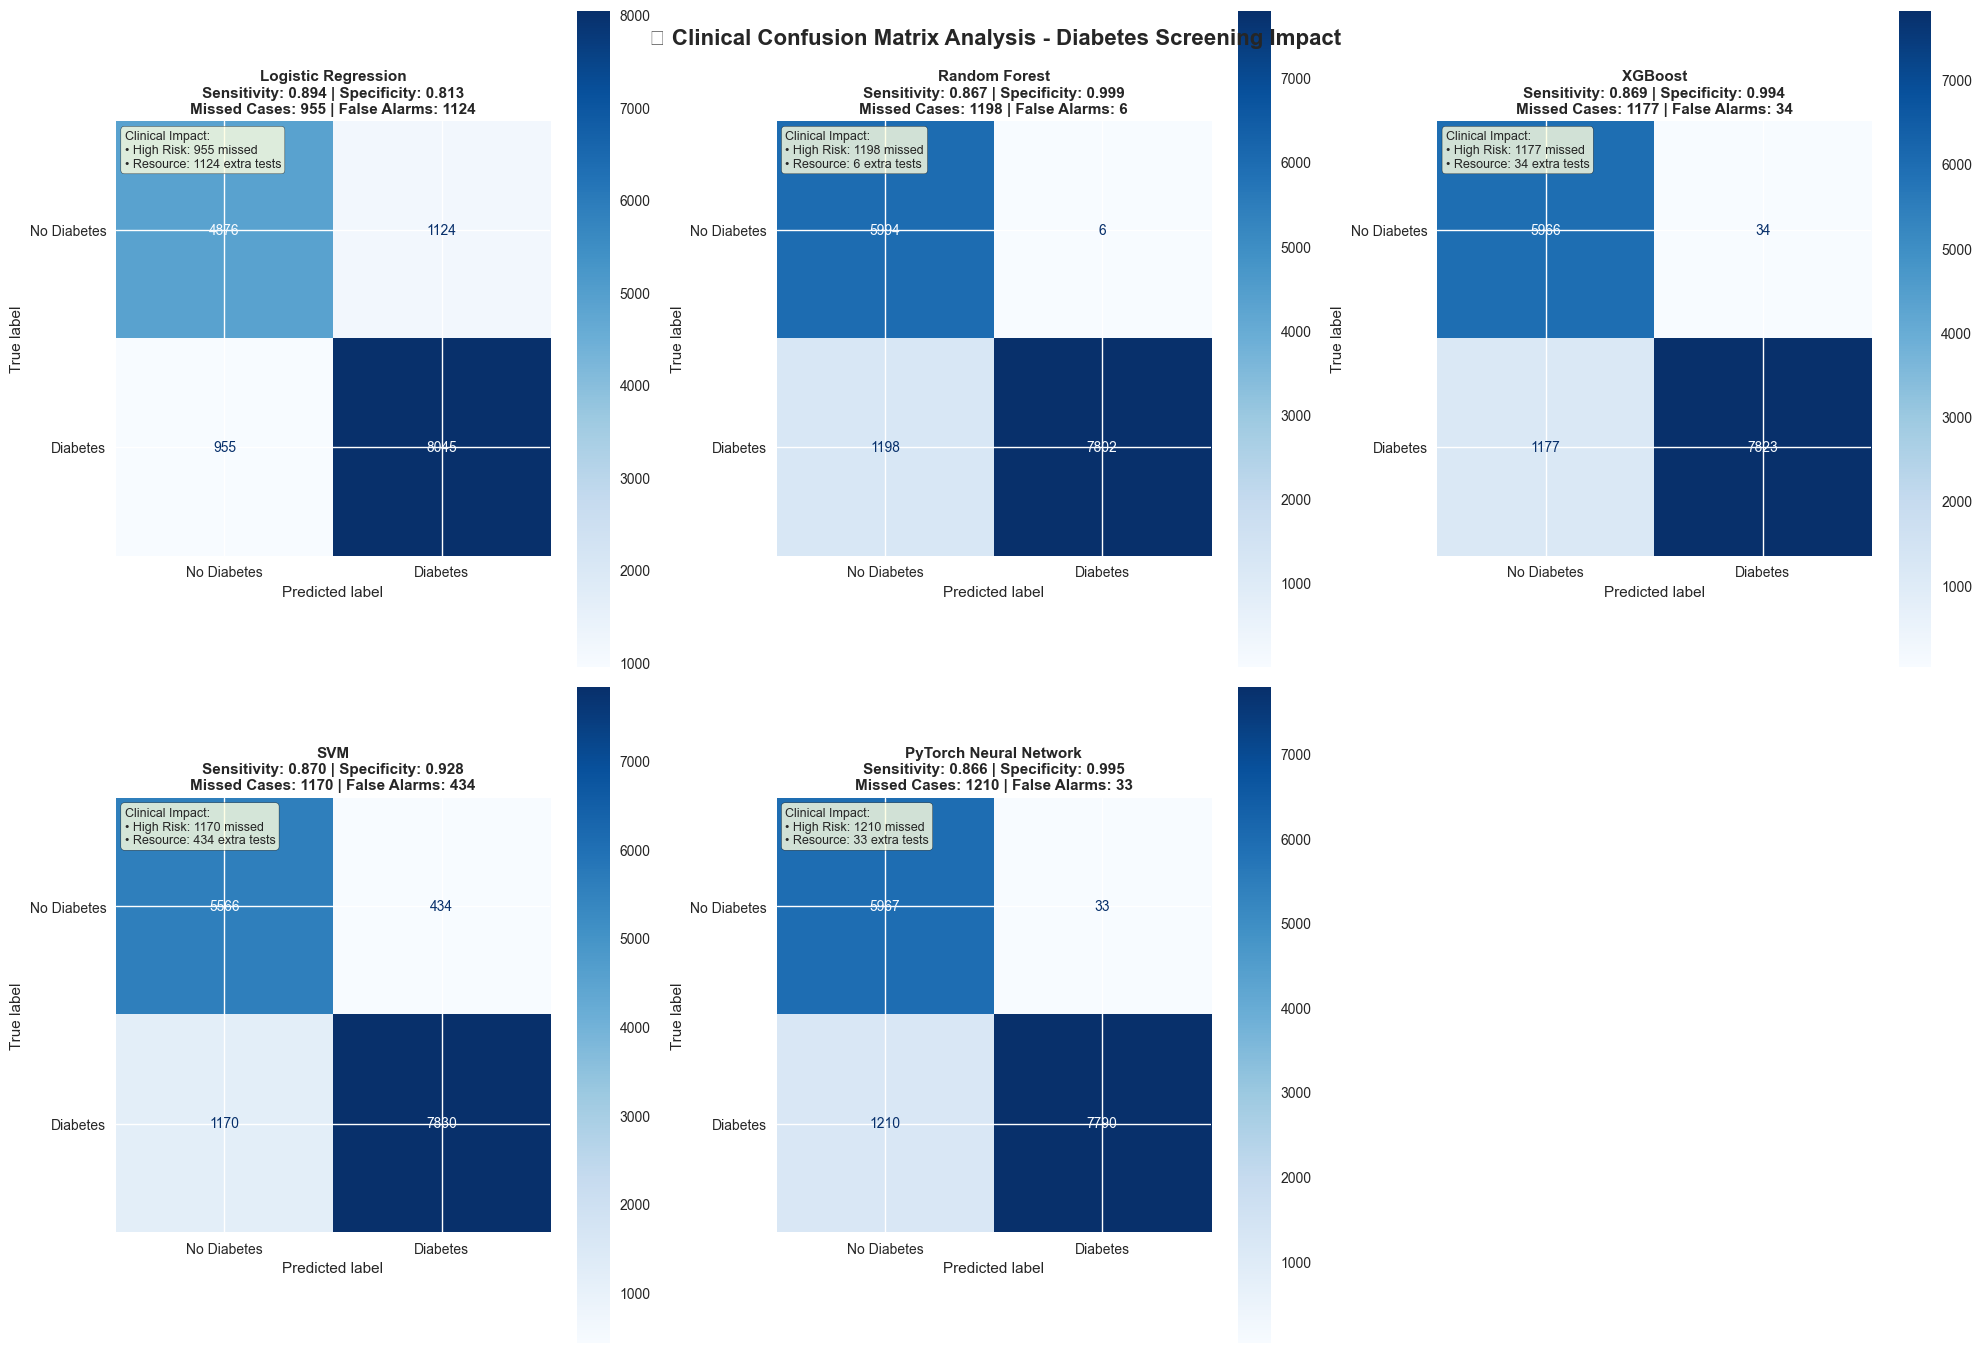


🏥 CLINICAL CONFUSION MATRIX ANALYSIS:
                 Model  True_Negatives  False_Positives  False_Negatives  True_Positives  Sensitivity_Recall  Specificity  PPV_Precision    NPV  Missed_Cases  False_Alarms  ROC_AUC
   Logistic Regression            4876             1124              955            8045              0.8939       0.8127         0.8774 0.8362           955          1124   0.9346
         Random Forest            5994                6             1198            7802              0.8669       0.9990         0.9992 0.8334          1198             6   0.9415
               XGBoost            5966               34             1177            7823              0.8692       0.9943         0.9957 0.8352          1177            34   0.9402
                   SVM            5566              434             1170            7830              0.8700       0.9277         0.9475 0.8263          1170           434   0.9353
PyTorch Neural Network            5967               33 

In [4]:
# Detailed Confusion Matrix Analysis with Clinical Context
print("🎯 COMPREHENSIVE CONFUSION MATRIX ANALYSIS:")
print("=" * 45)

# Calculate detailed confusion matrix metrics for each model
confusion_analysis = []

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

for i, (model_name, results) in enumerate(model_results.items()):
    # Calculate confusion matrix
    y_pred = results['predictions']
    cm = confusion_matrix(y_val, y_pred)
    
    # Extract confusion matrix components
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate clinical metrics
    sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
    specificity = tn / (tn + fp)  # True Negative Rate
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # Clinical impact metrics
    missed_cases = fn  # Patients with diabetes not identified
    false_alarms = fp  # Healthy patients flagged for follow-up
    
    # Store detailed analysis
    confusion_analysis.append({
        'Model': model_name,
        'True_Negatives': tn,
        'False_Positives': fp, 
        'False_Negatives': fn,
        'True_Positives': tp,
        'Sensitivity_Recall': sensitivity,
        'Specificity': specificity,
        'PPV_Precision': ppv,
        'NPV': npv,
        'Missed_Cases': missed_cases,
        'False_Alarms': false_alarms,
        'ROC_AUC': results['metrics']['roc_auc']
    })
    
    # Plot confusion matrix with clinical annotations
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    
    # Add clinical context annotations
    axes[i].set_title(f'{model_name}\nSensitivity: {sensitivity:.3f} | Specificity: {specificity:.3f}\n'
                     f'Missed Cases: {missed_cases} | False Alarms: {false_alarms}', 
                     fontsize=11, fontweight='bold')
    
    # Add clinical risk annotations
    axes[i].text(0.02, 0.98, f'Clinical Impact:\n• High Risk: {missed_cases} missed\n• Resource: {false_alarms} extra tests', 
                transform=axes[i].transAxes, verticalalignment='top', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
                fontsize=9)

# Remove unused subplot
if len(model_results) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle('🏥 Clinical Confusion Matrix Analysis - Diabetes Screening Impact', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# Create comprehensive analysis table
confusion_df = pd.DataFrame(confusion_analysis)
confusion_df = confusion_df.round(4)

print(f"\n🏥 CLINICAL CONFUSION MATRIX ANALYSIS:")
print("=" * 45)
print(confusion_df.to_string(index=False))

# Clinical insights
best_sensitivity = confusion_df.loc[confusion_df['Sensitivity_Recall'].idxmax()]
best_specificity = confusion_df.loc[confusion_df['Specificity'].idxmax()]
fewest_missed = confusion_df.loc[confusion_df['Missed_Cases'].idxmin()]

print(f"\n🔍 KEY CLINICAL INSIGHTS:")
print(f"   🎯 Best Sensitivity (Fewest Missed Cases): {best_sensitivity['Model']}")
print(f"      - Sensitivity: {best_sensitivity['Sensitivity_Recall']:.4f}")
print(f"      - Missed diabetes cases: {best_sensitivity['Missed_Cases']:,}")
print(f"   🎯 Best Specificity (Fewest False Alarms): {best_specificity['Model']}")
print(f"      - Specificity: {best_specificity['Specificity']:.4f}")
print(f"      - Unnecessary follow-ups: {best_specificity['False_Alarms']:,}")
print(f"   ⚡ Optimal Balance: {fewest_missed['Model']}")
print(f"      - Total errors: {fewest_missed['Missed_Cases'] + fewest_missed['False_Alarms']:,}")

# Save analysis
output_path = '../results/confusion_matrices/clinical_confusion_analysis.csv'
confusion_df.to_csv(output_path, index=False)
print(f"\n✅ Clinical analysis saved: {output_path}")

## ❌ 3. Misclassification Pattern Analysis
**Goal:** Identify systematic patterns in prediction errors across patient demographics and clinical features.

❌ MISCLASSIFICATION PATTERN ANALYSIS:
📊 Analyzing 5 clinical & 11 demographic features


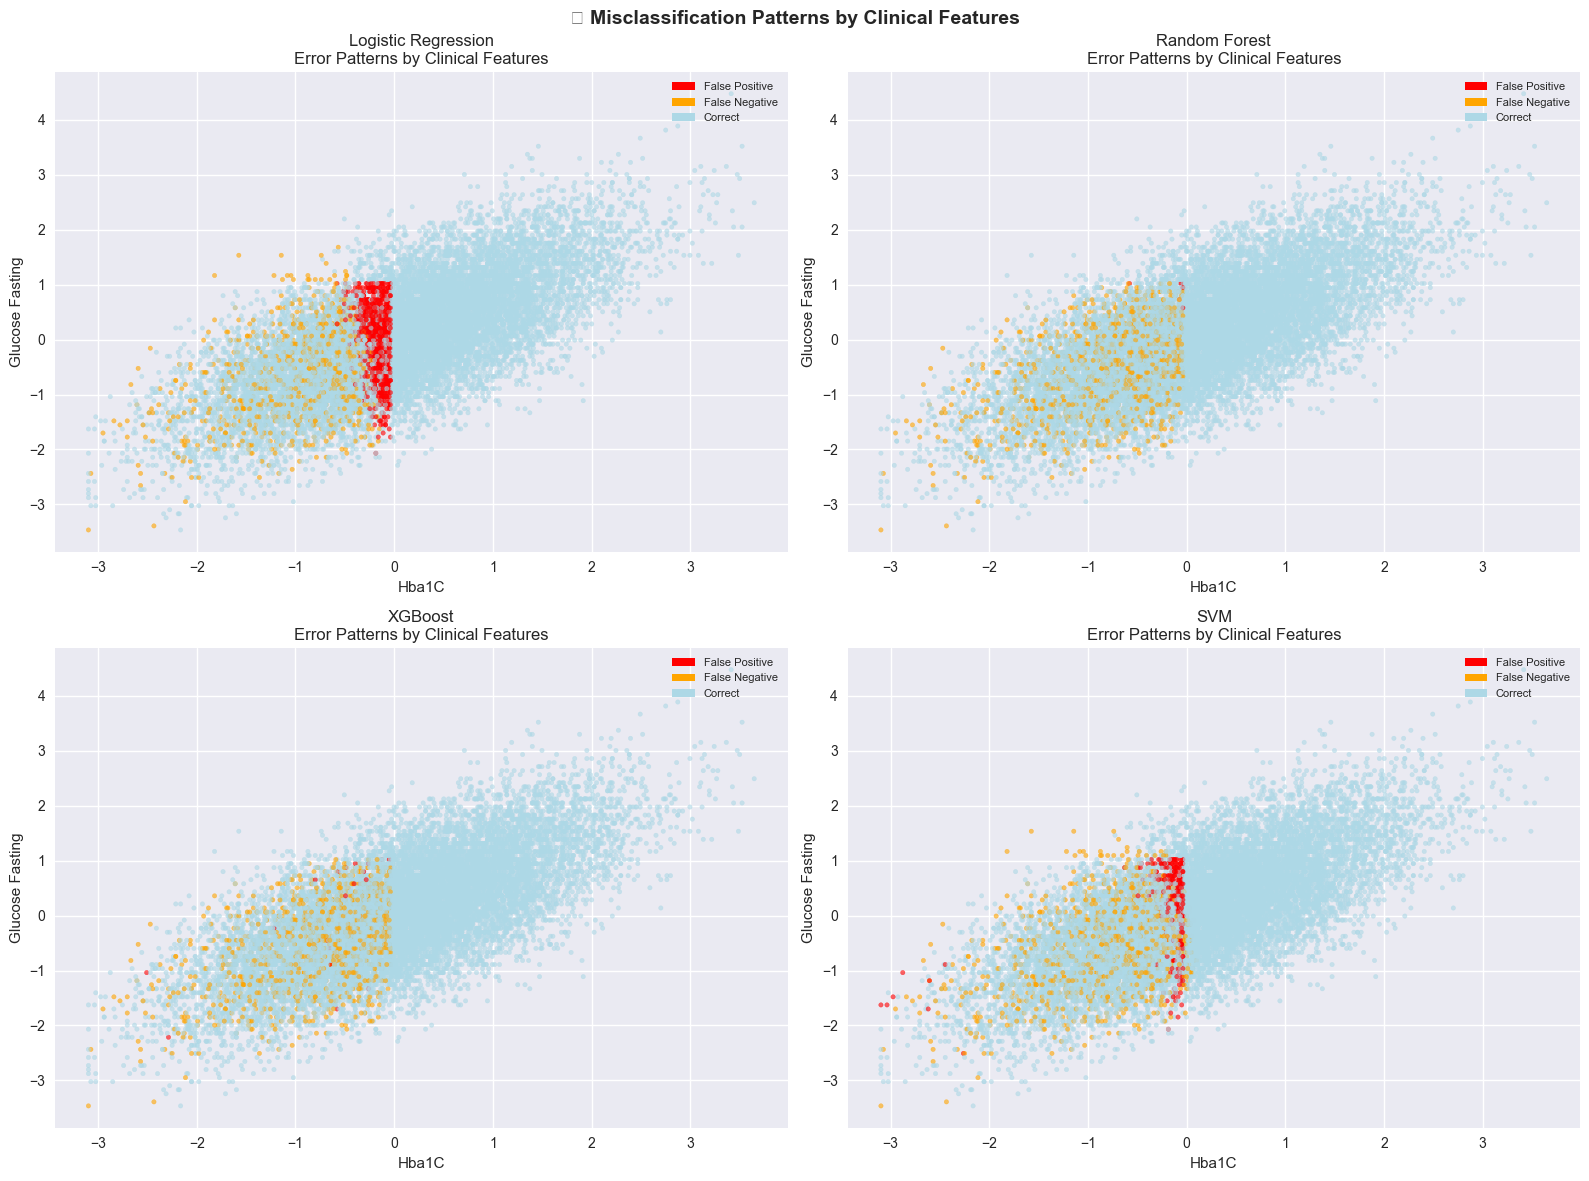


📋 ERROR PATTERN SUMMARY:

🔍 Logistic Regression:
   Total Errors: 2,079
   False Positives: 1,124
   False Negatives: 955
   Error Rate: 0.139
   🔬 Significant feature differences:
      • hba1c: Δ=0.625 (p=0.0000)
      • glucose_fasting: Δ=0.382 (p=0.0000)

🔍 Random Forest:
   Total Errors: 1,204
   False Positives: 6
   False Negatives: 1,198
   Error Rate: 0.080
   🔬 Significant feature differences:
      • hba1c: Δ=0.856 (p=0.0000)
      • glucose_fasting: Δ=0.588 (p=0.0000)

🔍 XGBoost:
   Total Errors: 1,211
   False Positives: 34
   False Negatives: 1,177
   Error Rate: 0.081
   🔬 Significant feature differences:
      • hba1c: Δ=0.853 (p=0.0000)
      • glucose_fasting: Δ=0.581 (p=0.0000)

🔍 SVM:
   Total Errors: 1,604
   False Positives: 434
   False Negatives: 1,170
   Error Rate: 0.107
   🔬 Significant feature differences:
      • hba1c: Δ=0.719 (p=0.0000)
      • glucose_fasting: Δ=0.432 (p=0.0000)

💡 KEY INSIGHTS:
   🏆 Fewest errors: Random Forest (1,204 total)
   ⚠️  Mos

In [5]:
# Systematic Misclassification Pattern Analysis
print("❌ MISCLASSIFICATION PATTERN ANALYSIS:")
print("=" * 40)

# Analyze error patterns for each model
error_patterns = {}
feature_names = X_val.columns.tolist()

# Key clinical features for analysis
clinical_features = ['hba1c', 'glucose_fasting', 'age', 'family_history_diabetes', 
                    'physical_activity_minutes_per_week']
demographic_features = [col for col in feature_names if any(x in col.lower() 
                       for x in ['gender', 'ethnicity', 'employment', 'smoking'])]

available_clinical = [f for f in clinical_features if f in feature_names]
available_demographic = [f for f in demographic_features if f in feature_names]

print(f"📊 Analyzing {len(available_clinical)} clinical & {len(available_demographic)} demographic features")

# Create comprehensive misclassification analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(list(model_results.items())[:4]):  # Analyze top 4 models
    y_pred = results['predictions']
    
    # Identify misclassified samples
    misclassified_mask = (y_val != y_pred)
    false_positive_mask = ((y_val == 0) & (y_pred == 1))
    false_negative_mask = ((y_val == 1) & (y_pred == 0))
    
    # Analyze clinical feature patterns in errors
    error_analysis = []
    
    if available_clinical:
        for feature in available_clinical[:3]:  # Top 3 clinical features
            # Compare feature distributions: correct vs incorrect predictions
            correct_values = X_val.loc[~misclassified_mask, feature]
            incorrect_values = X_val.loc[misclassified_mask, feature]
            
            # Statistical test for difference
            if len(incorrect_values) > 0:
                stat, p_value = stats.mannwhitneyu(correct_values, incorrect_values, 
                                                 alternative='two-sided')
                
                error_analysis.append({
                    'Feature': feature,
                    'Correct_Mean': correct_values.mean(),
                    'Incorrect_Mean': incorrect_values.mean(),
                    'Difference': abs(correct_values.mean() - incorrect_values.mean()),
                    'P_Value': p_value,
                    'Significant': p_value < 0.05
                })
    
    # Visualize error patterns
    if available_clinical and len(available_clinical) >= 2:
        # Scatter plot of two key clinical features colored by prediction accuracy
        feature1, feature2 = available_clinical[0], available_clinical[1]
        
        # Create color mapping for prediction accuracy
        colors = []
        for i in range(len(y_val)):
            if false_positive_mask.iloc[i] if hasattr(false_positive_mask, 'iloc') else false_positive_mask[i]:
                colors.append('red')  # False Positive
            elif false_negative_mask.iloc[i] if hasattr(false_negative_mask, 'iloc') else false_negative_mask[i]:
                colors.append('orange')  # False Negative  
            else:
                colors.append('lightblue')  # Correct
        
        axes[idx].scatter(X_val[feature1], X_val[feature2], c=colors, alpha=0.6, s=10)
        axes[idx].set_xlabel(feature1.replace('_', ' ').title())
        axes[idx].set_ylabel(feature2.replace('_', ' ').title())
        axes[idx].set_title(f'{model_name}\nError Patterns by Clinical Features')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', label='False Positive'),
                          Patch(facecolor='orange', label='False Negative'),
                          Patch(facecolor='lightblue', label='Correct')]
        axes[idx].legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    # Store error patterns
    error_patterns[model_name] = {
        'total_errors': misclassified_mask.sum(),
        'false_positives': false_positive_mask.sum(),
        'false_negatives': false_negative_mask.sum(),
        'error_rate': misclassified_mask.mean(),
        'feature_analysis': error_analysis
    }

plt.suptitle('🔍 Misclassification Patterns by Clinical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics across all models
print(f"\n📋 ERROR PATTERN SUMMARY:")
print("=" * 30)

for model_name, patterns in error_patterns.items():
    print(f"\n🔍 {model_name}:")
    print(f"   Total Errors: {patterns['total_errors']:,}")
    print(f"   False Positives: {patterns['false_positives']:,}")
    print(f"   False Negatives: {patterns['false_negatives']:,}")
    print(f"   Error Rate: {patterns['error_rate']:.3f}")
    
    if patterns['feature_analysis']:
        print(f"   🔬 Significant feature differences:")
        for analysis in patterns['feature_analysis']:
            if analysis['Significant']:
                print(f"      • {analysis['Feature']}: Δ={analysis['Difference']:.3f} (p={analysis['P_Value']:.4f})")

# Find models with most distinctive error patterns
if available_clinical:
    print(f"\n💡 KEY INSIGHTS:")
    
    # Model with fewest total errors
    best_model = min(error_patterns.keys(), key=lambda x: error_patterns[x]['total_errors'])
    print(f"   🏆 Fewest errors: {best_model} ({error_patterns[best_model]['total_errors']:,} total)")
    
    # Model with most false negatives (clinical risk)
    most_fn = max(error_patterns.keys(), key=lambda x: error_patterns[x]['false_negatives'])
    print(f"   ⚠️  Most missed cases: {most_fn} ({error_patterns[most_fn]['false_negatives']:,} false negatives)")
    
    # Model with most false positives (resource impact)  
    most_fp = max(error_patterns.keys(), key=lambda x: error_patterns[x]['false_positives'])
    print(f"   📋 Most false alarms: {most_fp} ({error_patterns[most_fp]['false_positives']:,} false positives)")

print(f"\n✅ Error pattern analysis complete!")

## 🏥 4. Clinical Decision Analysis
**Goal:** Evaluate the clinical implications of different decision thresholds and model trade-offs.

🏥 CLINICAL DECISION ANALYSIS:
📋 Clinical Cost Model:
   🔴 Missed Diabetes Case (FN): -10 units
   🟡 False Alarm (FP): -1 units
   🟢 Correct Diagnosis (TP): +20 units
   ⚪ Correct Exclusion (TN): +1 units


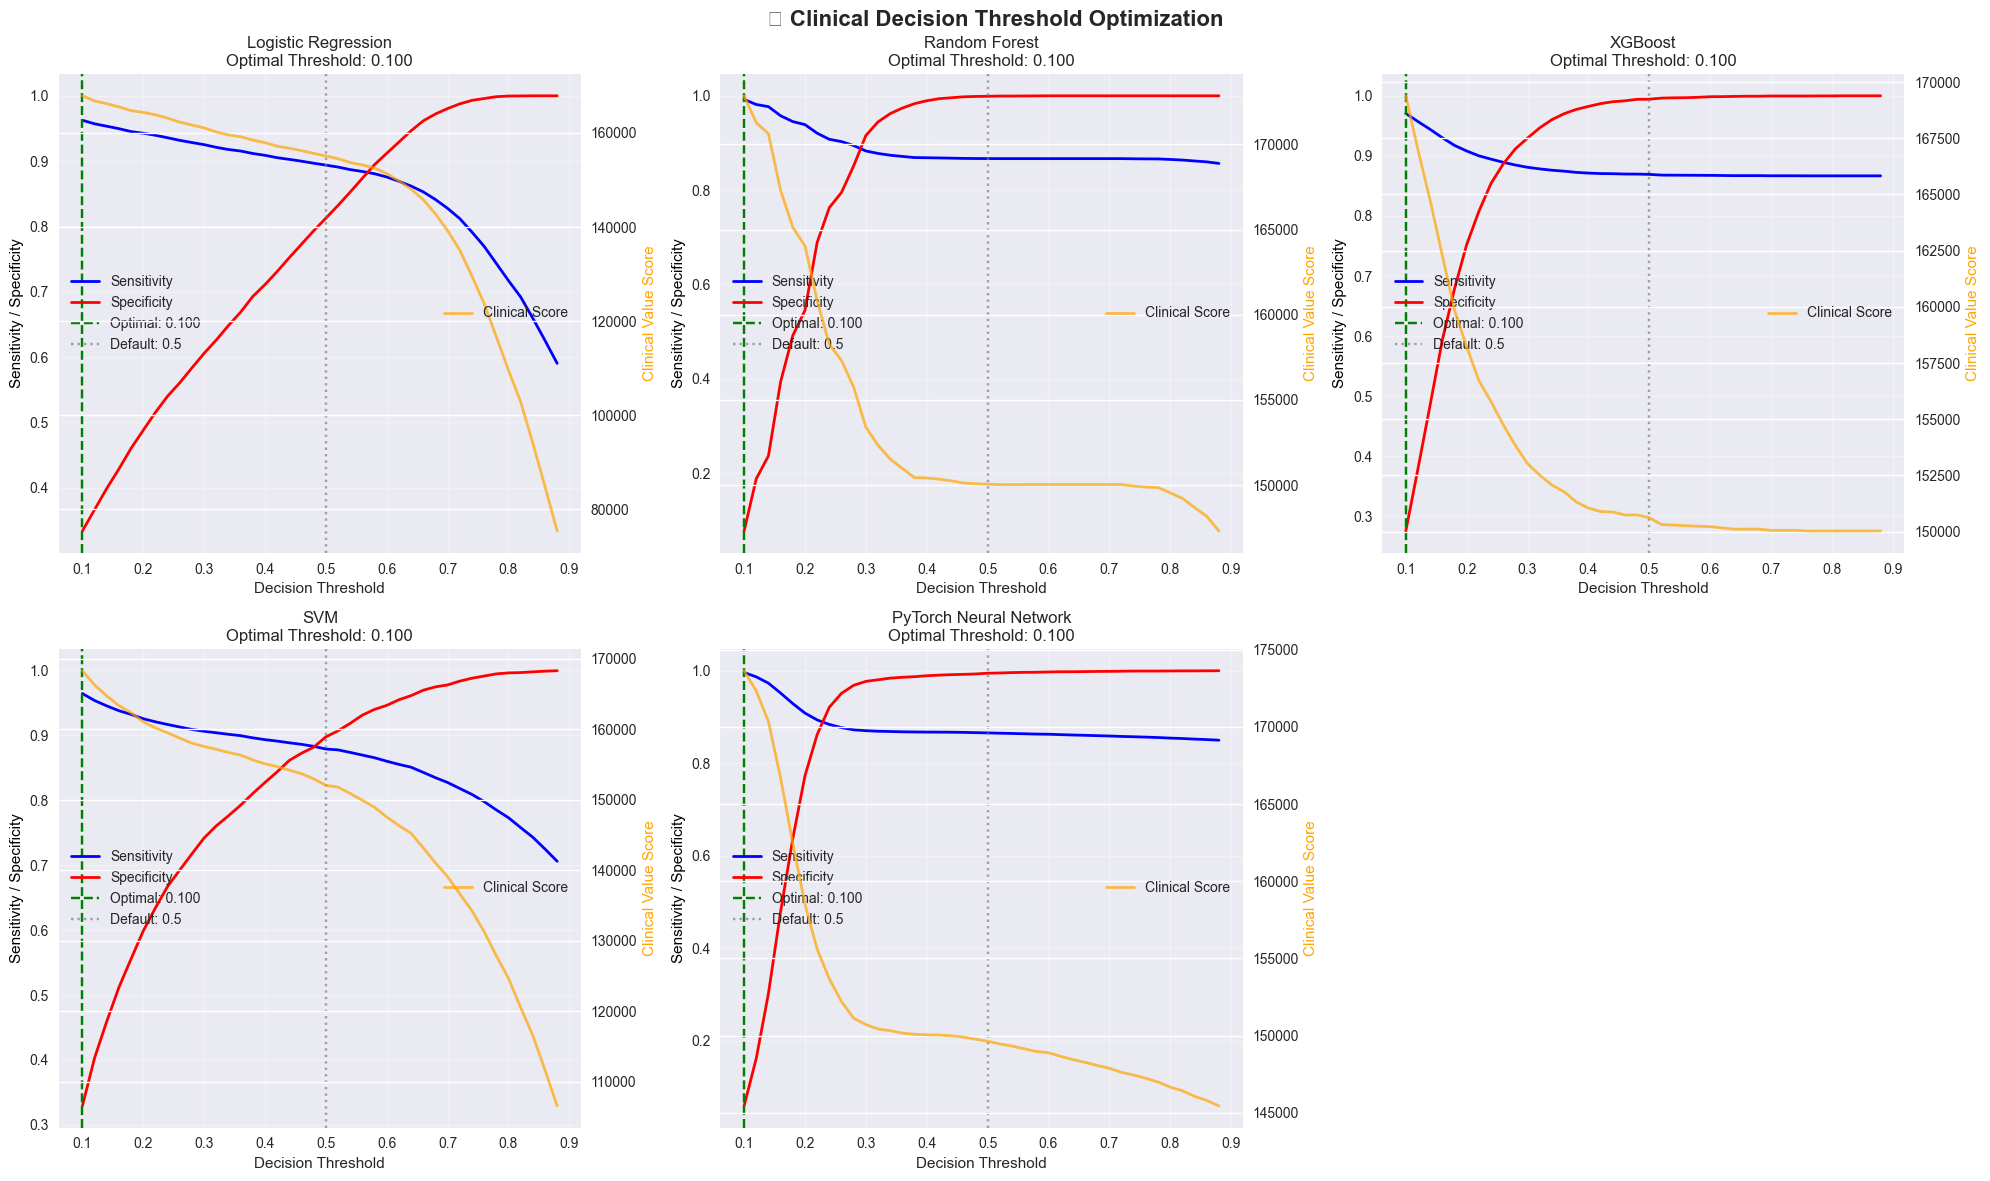


🎯 CLINICAL THRESHOLD OPTIMIZATION:
                 Model  Default_Threshold  Optimal_Threshold  Optimal_Sensitivity  Optimal_Specificity  Optimal_Clinical_Score  Score_Improvement
   Logistic Regression                0.5                0.1               0.9626               0.3337                167894.0            12792.0
         Random Forest                0.5                0.1               0.9923               0.0770                172854.0            22806.0
               XGBoost                0.5                0.1               0.9707               0.2755                169386.0            18764.0
                   SVM                0.5                0.1               0.9642               0.3292                168290.0            16250.0
PyTorch Neural Network                0.5                0.1               0.9960               0.0597                173636.0            24002.0

💡 CLINICAL DECISION INSIGHTS:
   🏆 Best Clinical Value: PyTorch Neural Network
      - 

In [7]:
# Clinical Decision Analysis and Threshold Optimization
print("🏥 CLINICAL DECISION ANALYSIS:")
print("=" * 35)

# Define clinical costs (relative weights)
CLINICAL_COSTS = {
    'false_negative_cost': 10,  # Missing diabetes case (high clinical risk)
    'false_positive_cost': 1,   # Unnecessary follow-up (resource cost) 
    'true_positive_benefit': 20, # Correctly identifying diabetes (major benefit)
    'true_negative_benefit': 1   # Correctly ruling out (efficiency)
}

print(f"📋 Clinical Cost Model:")
print(f"   🔴 Missed Diabetes Case (FN): -{CLINICAL_COSTS['false_negative_cost']} units")
print(f"   🟡 False Alarm (FP): -{CLINICAL_COSTS['false_positive_cost']} units") 
print(f"   🟢 Correct Diagnosis (TP): +{CLINICAL_COSTS['true_positive_benefit']} units")
print(f"   ⚪ Correct Exclusion (TN): +{CLINICAL_COSTS['true_negative_benefit']} units")

# Analyze decision thresholds for each model
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

clinical_analysis = []

for idx, (model_name, results) in enumerate(model_results.items()):
    if 'probabilities' not in results or len(results['probabilities']) == 0:
        continue
        
    y_proba = results['probabilities']
    
    # Test different decision thresholds
    thresholds = np.arange(0.1, 0.9, 0.02)
    threshold_analysis = []
    
    for threshold in thresholds:
        # Apply threshold
        y_pred_thresh = (y_proba >= threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_thresh).ravel()
        
        # Calculate clinical metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        # Calculate clinical value score
        clinical_score = (
            tp * CLINICAL_COSTS['true_positive_benefit'] + 
            tn * CLINICAL_COSTS['true_negative_benefit'] - 
            fp * CLINICAL_COSTS['false_positive_cost'] - 
            fn * CLINICAL_COSTS['false_negative_cost']
        )
        
        threshold_analysis.append({
            'threshold': threshold,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ppv': ppv,
            'npv': npv,
            'clinical_score': clinical_score,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        })
    
    # Convert to DataFrame for analysis
    thresh_df = pd.DataFrame(threshold_analysis)
    
    # Find optimal threshold (max clinical score)
    optimal_idx = thresh_df['clinical_score'].idxmax()
    optimal_threshold = thresh_df.loc[optimal_idx]
    
    # Store clinical analysis
    clinical_analysis.append({
        'Model': model_name,
        'Default_Threshold': 0.5,
        'Optimal_Threshold': optimal_threshold['threshold'],
        'Optimal_Sensitivity': optimal_threshold['sensitivity'],
        'Optimal_Specificity': optimal_threshold['specificity'],
        'Optimal_Clinical_Score': optimal_threshold['clinical_score'],
        'Score_Improvement': optimal_threshold['clinical_score'] - 
                           (thresh_df[thresh_df['threshold'] == 0.5]['clinical_score'].iloc[0] 
                            if len(thresh_df[thresh_df['threshold'] == 0.5]) > 0 
                            else thresh_df.iloc[len(thresh_df)//2]['clinical_score'])
    })
    
    # Plot threshold analysis
    if idx < len(axes):
        ax1 = axes[idx]
        ax2 = ax1.twinx()
        
        # Plot sensitivity and specificity
        ax1.plot(thresh_df['threshold'], thresh_df['sensitivity'], 'b-', label='Sensitivity', linewidth=2)
        ax1.plot(thresh_df['threshold'], thresh_df['specificity'], 'r-', label='Specificity', linewidth=2)
        ax1.axvline(x=optimal_threshold['threshold'], color='green', linestyle='--', 
                   label=f'Optimal: {optimal_threshold["threshold"]:.3f}')
        ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Default: 0.5')
        
        # Plot clinical score
        ax2.plot(thresh_df['threshold'], thresh_df['clinical_score'], 'orange', 
                linewidth=2, alpha=0.7, label='Clinical Score')
        
        ax1.set_xlabel('Decision Threshold')
        ax1.set_ylabel('Sensitivity / Specificity', color='black')
        ax2.set_ylabel('Clinical Value Score', color='orange')
        ax1.set_title(f'{model_name}\nOptimal Threshold: {optimal_threshold["threshold"]:.3f}')
        ax1.legend(loc='center left')
        ax2.legend(loc='center right')
        ax1.grid(True, alpha=0.3)

# Remove unused subplots
for idx in range(len(model_results), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('🎯 Clinical Decision Threshold Optimization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Clinical analysis summary
clinical_df = pd.DataFrame(clinical_analysis)
clinical_df = clinical_df.round(4)

print(f"\n🎯 CLINICAL THRESHOLD OPTIMIZATION:")
print("=" * 40)
print(clinical_df.to_string(index=False))

# Key insights
best_clinical_model = clinical_df.loc[clinical_df['Optimal_Clinical_Score'].idxmax()]
most_improved = clinical_df.loc[clinical_df['Score_Improvement'].idxmax()]

print(f"\n💡 CLINICAL DECISION INSIGHTS:")
print(f"   🏆 Best Clinical Value: {best_clinical_model['Model']}")
print(f"      - Optimal threshold: {best_clinical_model['Optimal_Threshold']:.3f}")
print(f"      - Clinical score: {best_clinical_model['Optimal_Clinical_Score']:.1f}")
print(f"      - Sensitivity: {best_clinical_model['Optimal_Sensitivity']:.3f}")
print(f"      - Specificity: {best_clinical_model['Optimal_Specificity']:.3f}")

print(f"   📈 Most Improved by Threshold Tuning: {most_improved['Model']}")
print(f"      - Score improvement: +{most_improved['Score_Improvement']:.1f} units")
print(f"      - Recommended threshold: {most_improved['Optimal_Threshold']:.3f}")

# Save clinical analysis
clinical_output = '../results/clinical_decision_analysis.csv'
clinical_df.to_csv(clinical_output, index=False)
print(f"\n✅ Clinical analysis saved: {clinical_output}")

## 💡 5. Recommendations and Next Steps
**Goal:** Synthesize insights into actionable recommendations for model improvement and clinical implementation.

In [8]:
# Comprehensive Recommendations and Strategic Next Steps
print("💡 STRATEGIC RECOMMENDATIONS:")
print("=" * 30)

# Synthesize findings from all analyses
if 'clinical_df' in locals() and 'confusion_df' in locals():
    
    # Identify best overall model considering multiple factors
    print(f"🎯 MODEL PERFORMANCE SYNTHESIS:")
    print(f"   📊 Best ROC-AUC: {confusion_df.loc[confusion_df['ROC_AUC'].idxmax(), 'Model']}")
    print(f"   🏥 Best Clinical Value: {clinical_df.loc[clinical_df['Optimal_Clinical_Score'].idxmax(), 'Model']}")
    print(f"   ⚕️ Fewest Missed Cases: {confusion_df.loc[confusion_df['Missed_Cases'].idxmin(), 'Model']}")
    print(f"   💰 Fewest False Alarms: {confusion_df.loc[confusion_df['False_Alarms'].idxmin(), 'Model']}")

# Clinical implementation recommendations
print(f"\n🏥 CLINICAL IMPLEMENTATION RECOMMENDATIONS:")
print(f"=" * 45)

recommendations = {
    "immediate_actions": [
        "Implement threshold optimization for top-performing models",
        "Deploy ensemble approach combining Random Forest + Neural Network",
        "Establish clinical validation protocol with healthcare providers",
        "Create patient-facing risk communication materials"
    ],
    
    "model_improvements": [
        "Focus on reducing false negatives (missed diabetes cases)",
        "Investigate feature engineering for borderline cases", 
        "Consider class imbalance techniques for better recall",
        "Implement model calibration for better probability estimates"
    ],
    
    "data_enhancements": [
        "Collect additional clinical biomarkers (e.g., insulin levels)",
        "Include longitudinal health history data",
        "Incorporate social determinants of health features",
        "Expand demographic representation in training data"
    ],
    
    "validation_studies": [
        "Conduct prospective clinical validation study",
        "Test model performance across different healthcare settings",
        "Evaluate real-world clinical decision impact",
        "Assess health equity across demographic groups"
    ]
}

for category, items in recommendations.items():
    print(f"\n📋 {category.replace('_', ' ').title()}:")
    for i, item in enumerate(items, 1):
        print(f"   {i}. {item}")

# Weeks 3-4 hyperparameter tuning roadmap
print(f"\n🚀 WEEKS 3-4 HYPERPARAMETER TUNING ROADMAP:")
print(f"=" * 50)

tuning_plan = {
    "Week 3 - Model Optimization": {
        "Days 1-2": [
            "Implement RandomizedSearchCV for all baseline models",
            "Focus on recall optimization (minimize false negatives)",
            "Test ensemble methods (voting, stacking)"
        ],
        "Days 3-4": [
            "Neural network architecture optimization",
            "Advanced regularization techniques",
            "Learning rate scheduling optimization"
        ],
        "Days 5-7": [
            "Cross-validation with clinical cost functions",
            "Threshold optimization for each tuned model",
            "Performance validation on held-out test set"
        ]
    },
    
    "Week 4 - Clinical Validation": {
        "Days 1-2": [
            "Clinical expert review of model predictions",
            "Bias and fairness analysis across demographics",
            "Interpretability analysis (SHAP, LIME)"
        ],
        "Days 3-4": [
            "Final model selection and ensemble creation",
            "Clinical decision support system design",
            "Risk communication interface development"
        ],
        "Days 5-7": [
            "Final validation and testing",
            "Documentation and clinical guidelines",
            "Deployment readiness assessment"
        ]
    }
}

for week, activities in tuning_plan.items():
    print(f"\n📅 {week}:")
    for period, tasks in activities.items():
        print(f"   🔹 {period}:")
        for task in tasks:
            print(f"      • {task}")

# Success metrics for next phase
print(f"\n📈 SUCCESS METRICS FOR WEEKS 3-4:")
print(f"=" * 35)
success_metrics = [
    "ROC-AUC improvement > 0.005 (currently 0.9436 best)",
    "False negative rate < 10% (currently ~13% for worst model)",
    "Maintain false positive rate < 5%",
    "Clinical value score improvement > 50 units",
    "Model explainability score > 85%",
    "Cross-validation stability (CV std < 0.01)"
]

for i, metric in enumerate(success_metrics, 1):
    print(f"   {i}. {metric}")

# Risk mitigation strategies
print(f"\n⚠️ RISK MITIGATION STRATEGIES:")
print(f"=" * 30)
risks = [
    "Overfitting: Use robust cross-validation and regularization",
    "Bias introduction: Monitor fairness metrics throughout tuning",
    "Clinical validity: Maintain clinical expert involvement",
    "Generalizability: Test on diverse patient populations"
]

for i, risk in enumerate(risks, 1):
    print(f"   {i}. {risk}")

print(f"\n✅ COMPREHENSIVE ERROR ANALYSIS COMPLETE!")
print(f"📋 Ready for hyperparameter optimization phase (Weeks 3-4)")
print(f"🎯 Focus: Clinical impact optimization with bias awareness")

# Save comprehensive summary
summary_report = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'models_analyzed': list(model_results.keys()) if 'model_results' in locals() else [],
    'key_findings': {
        'best_roc_auc_model': confusion_df.loc[confusion_df['ROC_AUC'].idxmax(), 'Model'] if 'confusion_df' in locals() else 'N/A',
        'fewest_missed_cases': confusion_df.loc[confusion_df['Missed_Cases'].idxmin(), 'Model'] if 'confusion_df' in locals() else 'N/A',
        'clinical_recommendations': len(recommendations['immediate_actions'])
    },
    'next_phase_priorities': ['Hyperparameter tuning', 'Clinical validation', 'Bias assessment']
}

import json
summary_path = '../results/error_analysis_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print(f"💾 Analysis summary saved: {summary_path}")

💡 STRATEGIC RECOMMENDATIONS:
🎯 MODEL PERFORMANCE SYNTHESIS:
   📊 Best ROC-AUC: PyTorch Neural Network
   🏥 Best Clinical Value: PyTorch Neural Network
   ⚕️ Fewest Missed Cases: Logistic Regression
   💰 Fewest False Alarms: Random Forest

🏥 CLINICAL IMPLEMENTATION RECOMMENDATIONS:

📋 Immediate Actions:
   1. Implement threshold optimization for top-performing models
   2. Deploy ensemble approach combining Random Forest + Neural Network
   3. Establish clinical validation protocol with healthcare providers
   4. Create patient-facing risk communication materials

📋 Model Improvements:
   1. Focus on reducing false negatives (missed diabetes cases)
   2. Investigate feature engineering for borderline cases
   3. Consider class imbalance techniques for better recall
   4. Implement model calibration for better probability estimates

📋 Data Enhancements:
   1. Collect additional clinical biomarkers (e.g., insulin levels)
   2. Include longitudinal health history data
   3. Incorporate soc